In [1]:
!pip install tensorflow


## Features Chosen

Candlestick patterns are a common tool used in technical analysis of stock. Candlesticks encapsulates 4 data points of a stock over a given point in time - Open, Close, High and Low. By tracking candlesticks over a period of time, traders try to find candlestick patterns which signal future price fluctuations. Often, Volume data is incorporated into this analysis (as increased trading volume is a signal of violatility). 

Therefore, I chose to incorporate NVDA's daily Open, Close, High, Low and Volume data as a time series to replicate the technical analysis performed using candlestick patterns.

However, I also wanted to include wider market and industry (beta) movements as a feature. This is because NVDA's stock price may lag external shocks by a day or two. Recent stock market performance informed my decision to choose the daily Nasdaq 100 index (NDX) close price to measure the influence of the wider market. I did not choose the S&P 500 due to the large uncoupling that has taken place between the technology sector and the overall market over the past two years. 

Final features - NVDA Open, Close, High, Low, Volume and NDX Close (in a timeseries). I decided to utilise a sliding window method which looks at the last 60 days of trading data and predicts the next 10 days.

## Model Chosen

As my dataset was in a time series, I chose an LSTM model due to it's strength in modeling long-term dependency and its ability to selectively forget irrelevant data as I imagined my dataset would have a lot of noise. 

However, as I discuss later down, I found an neural network of only LSTM layers was prone to overfitting to this particular dataset and eventually decided to implement a single LSTM layer followed by several feed-forward Dense layers.

In [4]:
from tensorflow import keras
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

In [5]:
NUMBER_OF_DAYS = 11  # Number of days price is predicted for (based on project parameters)
WINDOW = 60  
slice_date = 1500  

In [6]:
# Import NVDA Stock Data
ndva = pandas.read_csv("NVDA.csv")
ndva.set_index('Date', inplace=True)
ndva_first_index = ndva.index[0]

# Import NDX Index Data and match index to NVDA data
ndx = pandas.read_csv("^NDX.csv")
ndx.set_index('Date', inplace=True)
ndx = ndx.loc[ndva_first_index:]
ndx_filtered = ndx['Close']

# Combine NVDA and NDX data
data = ndva.copy()
data['NDX_Close'] = ndx_filtered

# Choose features 
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume', 'NDX_Close']
data_filtered = data[FEATURES]
data_filtered = data_filtered.iloc[slice_date:]
print(data_filtered)

                  Open        High         Low       Close     Volume  \
Date                                                                    
2005-01-10    1.841667    1.858333    1.829167    1.840000   57955200   
2005-01-11    1.822500    1.832500    1.755833    1.783333  109338000   
2005-01-12    1.799167    1.805833    1.725000    1.768333  105780000   
2005-01-13    1.772500    1.833333    1.733333    1.786667   89876400   
2005-01-14    1.820000    1.824167    1.775000    1.792500   57391200   
...                ...         ...         ...         ...        ...   
2023-10-17  440.000000  447.540009  424.799988  439.380005   81233300   
2023-10-18  425.910004  432.190002  418.250000  421.959991   62729400   
2023-10-19  428.109985  432.970001  418.820007  421.010010   50123300   
2023-10-20  418.899994  424.700012  410.779999  413.869995   47638100   
2023-10-23  412.290009  432.480011  409.450012  429.750000   47721800   

               NDX_Close  
Date                   

In [7]:
np_data = np.array(data_filtered)
# Scale dataset
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data)

# Seperate scaler to unscale predictions later
prediction_scaler = MinMaxScaler()
close_data = np.reshape(np.array(data_filtered['Close']), (-1, 1))
close_scaled = prediction_scaler.fit_transform(close_data)

index_Close = data_filtered.columns.get_loc("Close")


In [8]:
# Split training and test data
training_test_split = 0.7
split_data = int(np.ceil(np_data_scaled.shape[0] * training_test_split))
test_start_date = data_filtered.index[split_data]
training_data = np_data_scaled[0:split_data, :]
test_data = np_data_scaled[split_data - WINDOW:, :]


def add_dimension(window, data):
    x = []
    y = []

    for i in range(window, data.shape[0] - NUMBER_OF_DAYS):
        x.append(data[i - window:i, :])
        y.append(data[i:i + NUMBER_OF_DAYS, index_Close])

    x = np.array(x)
    y = np.array(y)
    return x, y


x_train, y_train = add_dimension(WINDOW, training_data)
x_test, y_test = add_dimension(WINDOW, test_data)


In [9]:
# Hyperparamters
intial_nodes = x_train.shape[1] * x_train.shape[2]
dropout_rate = 0.2
optimiser = 'adam'
validation_split = 0.1
epochs = 60 
batch_size = 32 #Tested 1, 16, 32

# Build model
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units=intial_nodes,
                            return_sequences=False,
                            input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(16))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(NUMBER_OF_DAYS))
model.compile(optimizer=optimiser, loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 360)               528480    
                                                                 
 dense (Dense)               (None, 32)                11552     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 11)                187       
                                                                 
Total params: 540747 (2.06 MB)
Trainable params: 540747 

In [17]:
# Train model
history = model.fit(x_train, y_train, epochs=epochs, validation_split=validation_split, batch_size=batch_size)

Epoch 1/60
92/92 [==============================] - 6s 65ms/step - loss: 1.6929e-06 - val_loss: 5.0811e-05
Epoch 2/60
92/92 [==============================] - 6s 64ms/step - loss: 1.6048e-06 - val_loss: 5.0453e-05
Epoch 3/60
92/92 [==============================] - 6s 65ms/step - loss: 1.5351e-06 - val_loss: 4.1186e-05
Epoch 4/60
92/92 [==============================] - 6s 65ms/step - loss: 1.5884e-06 - val_loss: 2.8088e-05
Epoch 5/60
92/92 [==============================] - 6s 65ms/step - loss: 1.6441e-06 - val_loss: 4.2211e-05
Epoch 6/60
92/92 [==============================] - 6s 65ms/step - loss: 1.5814e-06 - val_loss: 2.6016e-05
Epoch 7/60
92/92 [==============================] - 6s 66ms/step - loss: 1.7999e-06 - val_loss: 9.5650e-05
Epoch 8/60
92/92 [==============================] - 6s 65ms/step - loss: 1.6778e-06 - val_loss: 5.8973e-05
Epoch 9/60
92/92 [==============================] - 6s 66ms/step - loss: 1.5426e-06 - val_loss: 3.0963e-05
Epoch 10/60
92/92 [==================

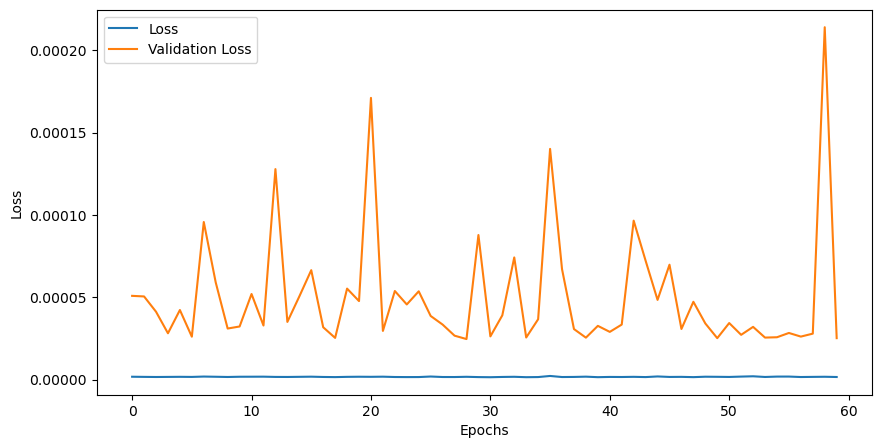

In [18]:
# Plot loss against epochs to check for overfitting
loss_hist = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10, 5))
plt.plot(loss_hist, label="Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Loss v Epoch graph

The validation loss does not show any upward trend as the model is trained so there are no signs of overfitting. However, validation loss didn't converge with the loss curve as I expected, there might be some underfitting.

44/44 [==============================] - 1s 22ms/step


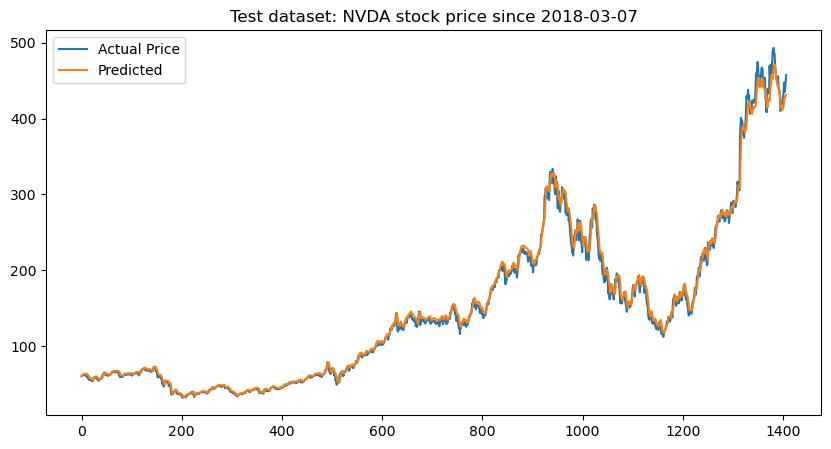

In [19]:
# Test
y_pred_scaled = model.predict(x_test)
y_pred = prediction_scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = prediction_scaler.inverse_transform(y_test)

# Plot actual vs predicted prices
# Plotted price is the first day of the 10 days predicted (to act as a proxy for overall accuracy)
plot_y_test = []
plot_y_pred = []
for i in range(y_test_unscaled.shape[0]):
    plot_y_test.append(y_test_unscaled[i][0])
    plot_y_pred.append(y_pred[i][0])

plt.figure(figsize=(10, 5))
plt.plot(plot_y_test, label='Actual Price')
plt.plot(plot_y_pred, label='Predicted')
plt.title(label=f"Test dataset: NVDA stock price since {test_start_date}")
plt.legend()
plt.show()

## Reflection on model performance and settling on final model

Before landing on my final prediction model, I tested different iterations of my model (e.g. differing hyperparamters, differing neural network structure). Across all these iterations, I found a unifying trend - the predicted prices were consistenly below the actual price of the stock (underpredicting). Furthermore, I noticed that the divergence worsened for the most recent dates. 

Eventually, I identified the main problems to be too many LSTM layers which were "remembering" too much historical data and pulling down the predicted prices. This phenomena was worse for recent dates (possibly) due to NVDA's bull run in 2023. Therefore, I limited my model to 1 LSTM layer and have seen improved results. 

## Hypothesis 

Based on the above observations, I hypothesised that the model was scaling down its predictions in some consistent manner. To test this, I plotted the error rate of the predictions to check if the error follows any discernable distribution.

I also wanted to check if the errors were worse for the most recent trading days. 

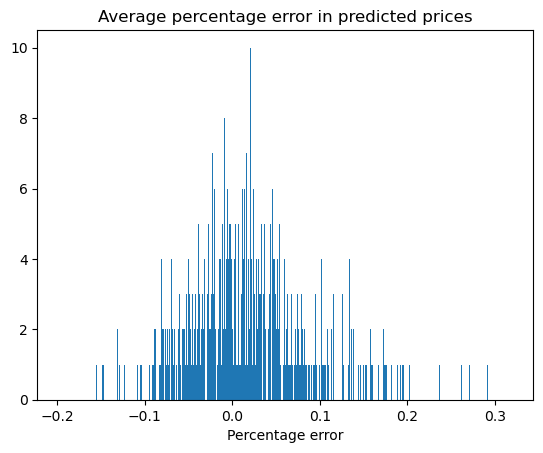

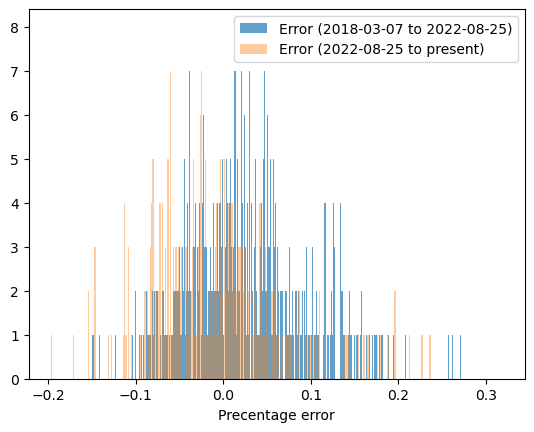

In [20]:
#Find difference between predicted and actual prices in test data
difference = y_pred - y_test_unscaled
avg_diff = np.mean(difference, axis=1)
y_test_avg = np.mean(y_test_unscaled, axis=1)

#Convert price difference into percentage error
error_perc = []
for i in range(avg_diff.shape[0]):
    error_perc.append(avg_diff[i] / y_test_avg[i])

# Check whether percentage error roughly follows a normal distribution.
plt.hist(error_perc, bins=len(error_perc))
plt.title("Average percentage error in predicted prices")
plt.xlabel('Percentage error')
plt.show()

#I split the test data into two to check if the model underpredicted for later dates more than for earlier dates
slice_test = int(np.ceil(0.8*y_test.shape[0]))
error_perc_early = error_perc[0:slice_test]
error_perc_recent = error_perc[slice_test:]
barrier_date = data_filtered.index[split_data + slice_test]
plt.hist(error_perc_early, bins=len(error_perc_early), label=f"Error ({test_start_date} to {barrier_date})", alpha=0.7)
plt.hist(error_perc_recent, bins=len(error_perc_recent), label=f"Error ({barrier_date} to present)", alpha=0.4)
plt.xlabel('Precentage error')
plt.legend()
plt.show()

## Analysing histogram 

Throughout my testing, I found that the error rates on the predictions did in fact seem to follow a sort of normal distribution. However, in my final model, there was no significant bias towards underprediction (as seen in the first graph).


Furthermore, as seen in the second graph, the distribution is not random - the predictions are more underpredicted for recent dates. I was initially going to adjust all my predicitions with the average error produced in the test dataset. However, I opted against it as it didn't seem to be a systematic method and the lack of random distribution would make the error correction inprecise. 



In [21]:
# Metric testing
MSE_scaled = mean_squared_error(y_test, y_pred_scaled)
RMSE_scaled = sqrt(MSE_scaled)
print(f"Scaled RMSE is {RMSE_scaled}")


MSE_unscaled = mean_squared_error(y_test_unscaled, y_pred)
RMSE_unscaled = sqrt(MSE_unscaled)
print(f"RMSE is {RMSE_unscaled}")


Scaled RMSE is 0.030902088093205316
RMSE is 15.206144828436642


In [22]:
#Make predictions
project_test_set = [np_data_scaled[len(np_data_scaled) - WINDOW:len(np_data_scaled), :]]
project_test_set = np.array(project_test_set)
project_predict_scaled = model.predict(project_test_set)
final_predict = prediction_scaler.inverse_transform(project_predict_scaled)
final_predict = np.transpose(final_predict)

#Format predictions as DataFrame
predicted_dates = ['2023-10-24','2023-10-25', '2023-10-26', '2023-10-27', '2023-10-30', '2023-10-31',
                   '2023-11-01', '2023-11-02', '2023-11-03', '2023-11-06', '2023-11-07']

df = pandas.DataFrame(final_predict, index=predicted_dates, columns=['Close'])
df.index.name = 'Date'
print(df)


1/1 [==============================] - 0s 16ms/step
                 Close
Date                  
2023-10-24  414.418396
2023-10-25  412.031219
2023-10-26  408.684357
2023-10-27  406.864441
2023-10-30  413.043732
2023-10-31  417.816376
2023-11-01  422.995697
2023-11-02  425.004822
2023-11-03  418.336365
2023-11-06  421.306885
2023-11-07  435.494385


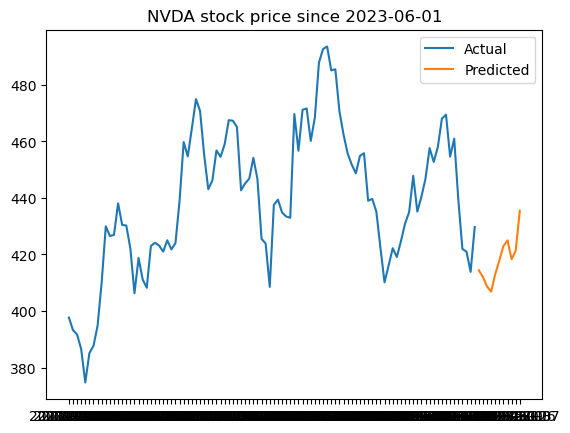

In [23]:
#Plot predicted price with actual price since June 2023
plot_start_date = '2023-06-01'
visual_data = data_filtered.loc[plot_start_date:]
plt.plot(visual_data.index.values, visual_data['Close'], label='Actual')
plt.plot(df.index.values, df['Close'], label='Predicted')
plt.title(label=f"NVDA stock price since {plot_start_date}")
plt.legend()
plt.show()


## Final Thoughts

Despite reducing underprediction in my model while testing, I still have the sense the latest iteration of my model is underpredicting prices. This is probably because 2023 has been an anamoulous year of trading for NVDA and my training dataset ends in 2018. Ideally, I would like to allow the model to train on data drawn from across the entire timeseries but due to the sequential nature of the data, I was not not able to scramble the data. 

I would also thinking about whether I would have been able to predict 10 days of trading prices sequentially rather than at one go as I suspect this might have been more accurate. However, this would only work if my input data was 2 dimensional (only using 'NVDA Close' price as a feature).

Lastly, it would have served me well to automate testing with different hyperparameters and officially document the different tests I conducted rather than taking informal notes. 

Overall, I think the project helped me develop some intuition about how the different hyperparamaters and model architecture affect by predictions. I was driven to conduct data analysis on my predictions and I was able to successfully identify excessive LSTM layers as the root of the inaccuracy